In [164]:
import pandas as pd
import re
import nltk
import spacy
import math
import seaborn as sns


nltk.download("stopwords")
nlp = spacy.load("en_core_web_sm")
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\naabe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\naabe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\naabe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
path = "Scripts TBBT.csv"
df = pd.read_csv(path , sep = "," , skipinitialspace=True, engine="python")

df = df[df['person_scene'].str.contains('Amy')]
df

,episode_name,dialogue,person_scene
15116,Series 03 Episode 23 – The Lunar Excitation,Excuse me. I’m Amy Farrah Fowler. You’re Sheld...,Amy
15118,Series 03 Episode 23 – The Lunar Excitation,"If that was slang, I’m unfamiliar with it. If...",Amy
15120,Series 03 Episode 23 – The Lunar Excitation,"I don’t object to the concept of a deity, but...",Amy
15122,Series 03 Episode 23 – The Lunar Excitation,"Noted. Now, before this goes any further, you...",Amy
15124,Series 03 Episode 23 – The Lunar Excitation,"Tepid water, please.",Amy
...,...,...,...
54344,Series 10 Episode 24 – The Long Distance Disso...,I was missing you again.,Amy
54346,Series 10 Episode 24 – The Long Distance Disso...,She’s what?,Amy
54348,Series 10 Episode 24 – The Long Distance Disso...,Hi.,Amy
54350,Series 10 Episode 24 – The Long Distance Disso...,Uh-huh. Hang on. (answering phone) Hello. A l...,Amy


In [4]:
data = df['dialogue']
data

15116    Excuse me. I’m Amy Farrah Fowler. You’re Sheld...
15118     If that was slang, I’m unfamiliar with it. If...
15120     I don’t object to the concept of a deity, but...
15122     Noted. Now, before this goes any further, you...
15124                                 Tepid water, please.
                               ...                        
54344                             I was missing you again.
54346                                          She’s what?
54348                                                  Hi.
54350     Uh-huh. Hang on. (answering phone) Hello. A l...
54352                                  It’s not important.
Name: dialogue, Length: 3420, dtype: object

In [5]:
def clean_text(text):
    # clean punctuation
    text = re.sub(r"[’!”#$%&()*+,-.:;?@[\]^_`{|}~]", "", str(text))
    # lower
    return text.lower()

In [6]:
def process_words(text):
    # tokenization
    sentences = nltk.tokenize.sent_tokenize(text)
    words = nltk.tokenize.word_tokenize(text)
    # remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    filter_words = [word for word in words if word not in stop_words]
    # stemming
    porter = nltk.stem.PorterStemmer()
    stemmed_words = [porter.stem(word) for word in filter_words]
    return {
        "sentences" : sentences,
        "filtered_words" : filter_words,
        "stemmed_words" : stemmed_words
    }

In [7]:
def pos_ner(text):
    doc = nlp(text)
    pos_tag = [(token.text, token.pos_) for token in doc]
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return {
        "pos_tags": pos_tag,
        "entities" : entities
    }

In [13]:
processed_data = []
for text in data:
    cleaned = clean_text(text)
    processed = process_words(cleaned)
    ner_pos = pos_ner(" ".join(processed["filtered_words"]))
    processed_data.append({
        "org_text": text,
        "cleaned_text": cleaned,
        "filtered_words": processed["filtered_words"],
        "stemmed_words": processed["stemmed_words"],
        "pos_tags": ner_pos["pos_tags"],
        'entities': ner_pos['entities']
    }
    )

In [14]:
for i, data in enumerate(processed_data):
    if "pos_tags" not in data:
        print(f"Missing 'pos_tags' in entry {i}: {data}")

In [15]:
df['filtered_words'] = [data['filtered_words'] for data in processed_data]
df['stemmed_words'] = [data['stemmed_words'] for data in processed_data]
df['pos_tags'] = [data["pos_tags"] for data in processed_data]
df['entities'] = [data['entities'] for data in processed_data]


In [16]:
df.to_csv('processed_data.csv', index=False)

In [17]:
# Question 3

df['season'] = df['episode_name'].str.extract(r'Series (\d+)').astype(int)
df['episode'] = df['episode_name'].str.extract(r'Episode (\d+)').astype(int)
df['season_episode'] = df['season'].astype(str) + '-' + df['episode'].astype(str)
dialogue_list = df['filtered_words'].sum()

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(dialogue_list)
feature_names = tfidf_vectorizer.get_feature_names_out()

In [19]:
import numpy as np

def get_top_words(tfidf_matrix, feature_names, top_n=3):
    scores = np.sum(tfidf_matrix, axis=0).A1  # Sum TF-IDF scores across rows
    top_indices = np.argsort(scores)[::-1][:top_n]
    return [(feature_names[i], scores[i]) for i in top_indices]


In [20]:
total_tfidf_matrix = tfidf_vectorizer.fit_transform(dialogue_list)
top_10_words = get_top_words(tfidf_matrix, feature_names, top_n=10)
for i, word in enumerate(top_10_words):
    print(f"Top {i+1} Words:", word[0])

Top 1 Words: im
Top 2 Words: sheldon
Top 3 Words: dont
Top 4 Words: know
Top 5 Words: well
Top 6 Words: like
Top 7 Words: youre
Top 8 Words: oh
Top 9 Words: thats
Top 10 Words: get


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Grouping by Season
season_dialogues = df.groupby('season')['filtered_words'].apply(lambda x: ' '.join(sum(x, [])))
season_tfidf_matrix = tfidf_vectorizer.fit_transform(season_dialogues)

# Get top words for each season
for season, tfidf_matrix in enumerate(season_tfidf_matrix):
    top_words = get_top_words(tfidf_matrix, feature_names)
    print(f"Season {season + 3} Top Words:")
    for i in range(len(top_words)):
        print(i+1, top_words[i][0])
    print()


Season 3 Top Words:
1 im
2 noted
3 baffled

Season 4 Top Words:
1 im
2 dont
3 well

Season 5 Top Words:
1 im
2 like
3 youre

Season 6 Top Words:
1 sheldon
2 im
3 like

Season 7 Top Words:
1 sheldon
2 im
3 like

Season 8 Top Words:
1 im
2 sheldon
3 okay

Season 9 Top Words:
1 know
2 im
3 well

Season 10 Top Words:
1 well
2 sheldon
3 dont



In [22]:
# Episode level
# Grouping by episode 
episode_dialogues = df.groupby('season_episode')['filtered_words'].apply(lambda x: ' '.join(sum(x, [])))
episode_tfidf_matrix = tfidf_vectorizer.fit_transform(episode_dialogues)

# Get top words for each episode 
episodes = df['season_episode'].unique()
for i, tfidf_matrix in enumerate(episode_tfidf_matrix):
    print(f"Episode {episodes[i]} Top Words:", get_top_words(tfidf_matrix, feature_names))
    print()

Episode 3-23 Top Words: [('disrespectful', 0.24354629002393124), ('airport', 0.2250893941414172), ('hitting', 0.2250893941414172)]

Episode 4-1 Top Words: [('selfish', 0.28556515557382856), ('keep', 0.19002310756392368), ('little', 0.18896080482900762)]

Episode 4-3 Top Words: [('scotch', 0.22619833889019045), ('trains', 0.20905613898526215), ('birthday', 0.17975135468918343)]

Episode 4-5 Top Words: [('blah', 0.4467047041891381), ('help', 0.1709043982398567), ('trip', 0.16022308721104667)]

Episode 4-8 Top Words: [('miss', 0.3233620509033735), ('bye', 0.268088073433222), ('girls', 0.24252153817753014)]

Episode 4-10 Top Words: [('machine', 0.27304057691083755), ('im', 0.22300407957663787), ('smudge', 0.21964324012169317)]

Episode 4-13 Top Words: [('renaissance', 0.21914635747170416), ('early', 0.21914635747170416), ('music', 0.18159544376743447)]

Episode 4-14 Top Words: [('secrets', 0.21658308978330612), ('date', 0.19145679351759307), ('oh', 0.1821790569503111)]

Episode 4-15 Top Wo

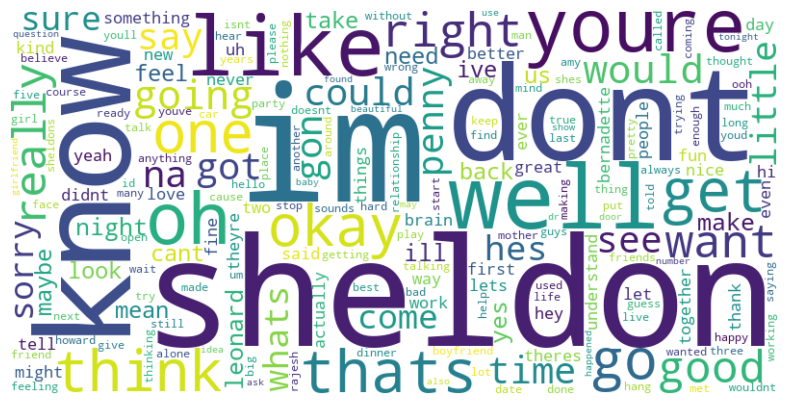

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(tfidf_matrix, feature_names):
    scores = np.sum(tfidf_matrix, axis=0).A1
    word_scores = {feature_names[i]: scores[i] for i in range(len(scores))}
    wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_scores)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

plot_wordcloud(total_tfidf_matrix, feature_names)

Quesiton 4

 Examine the co-occurence of words for your character by using the Positive Poin
twise Mutual Information measurement. Which words are commonly used together in
 his/her dialogues? Remark: You can try to make a Word-Word co-occurence matrix.


In [158]:
# getting the sentences
tokenized_sentences = df['filtered_words']

In [159]:
#co-occurence matrix
def build_cooccurrence_matrix(tokenized_sentences, window_size=2):
    unique_words = set(word for sentence in tokenized_sentences for word in sentence)
    unique_words = list(unique_words)
    word_to_id = {word: idx for idx, word in enumerate(unique_words)}
    id_to_word = {idx: word for word, idx in word_to_id.items()}

    # Initialize matrix
    cooccurrence_matrix = np.zeros((len(unique_words), len(unique_words)))

    for sentence in tokenized_sentences:
        for idx, word in enumerate(sentence):
            word_id = word_to_id[word]

            # Look at words within the context window
            start = max(idx - window_size, 0)
            end = min(idx + window_size + 1, len(sentence))
            
            for context_idx in range(start, end):
                if idx != context_idx:
                    context_word = sentence[context_idx]
                    context_id = word_to_id[context_word]
                    cooccurrence_matrix[word_id, context_id] += 1

    return cooccurrence_matrix, word_to_id, id_to_word


In [160]:
#compute PPMI

def compute_ppmi(cooccurrence_matrix):
    total_count = np.sum(cooccurrence_matrix)
    word_sums = np.sum(cooccurrence_matrix, axis=1)
    ppmi_matrix = np.zeros_like(cooccurrence_matrix)

    for i in range(cooccurrence_matrix.shape[0]):
        for j in range(cooccurrence_matrix.shape[1]):
            if cooccurrence_matrix[i, j] > 0:
                p_ij = cooccurrence_matrix[i, j] / total_count
                p_i = word_sums[i] / total_count
                p_j = word_sums[j] / total_count
                ppmi = max(np.log2(p_ij / (p_i * p_j)), 0)
                ppmi_matrix[i, j] = ppmi

    return ppmi_matrix


 Which are the words commonly used together?

In [161]:
def top_word_pairs(ppmi_matrix, id_to_word, top_n=20):
    word_pairs = []

    # Extracting non-diagonal word pairs where PPMI > 0
    for i in range(ppmi_matrix.shape[0]):
        for j in range(i+1, ppmi_matrix.shape[1]):  # Ignore the diagonal
            if ppmi_matrix[i, j] > 0:
                word_pairs.append((id_to_word[i], id_to_word[j], ppmi_matrix[i, j]))

    # sorting by descending order
    sorted_pairs = sorted(word_pairs, key=lambda x: x[2], reverse=True)
    return sorted_pairs[:top_n]

top_pairs = top_word_pairs(ppmi_matrix, id_to_word, top_n=20)

# Display the results
for word1, word2, score in top_pairs:  
    print(f"{word1} - {word2}: {score:.2f}")

graciously - accept: 15.83
unit - storage: 15.83
sporting - equipment: 15.83
yo - pdog: 15.83
lowhanging - fruit: 15.83
sings - mandarin: 15.83
magnets - atomic: 15.83
traffic - sailing: 15.83
bayonets - tuned: 15.83
pigs - freaking: 15.83
yup - killin: 15.83
rising - rapidly: 15.83
cleanup - crew: 15.83
episodes - 232: 15.83
intended - pun: 15.83
obsessivecompulsive - disorder: 14.25
quivers - uterus: 14.25
si - size: 14.25
floppy - disk: 13.83
tyson - mike: 13.83


In [162]:
def word_pair_heatmap(ppmi_matrix, top_pairs, word_to_id):

    # Extract words and build sub-matrix
    words = list(set([w1 for w1, w2, _ in top_pairs] + [w2 for w1, w2, _ in top_pairs]))
    word_indices = [word_to_id[w] for w in words if w in word_to_id]
    
    # Extract relevant sub-matrix
    sub_matrix = ppmi_matrix[np.ix_(word_indices, word_indices)]

    # Create DataFrame for visualization
    df = pd.DataFrame(sub_matrix, index=words, columns=words)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(df, cmap="rocket", annot=True, fmt=".2f", linewidths=.5)
    plt.title("Top Word Pair Co-occurrence Heatmap (PPMI)")
    plt.show()


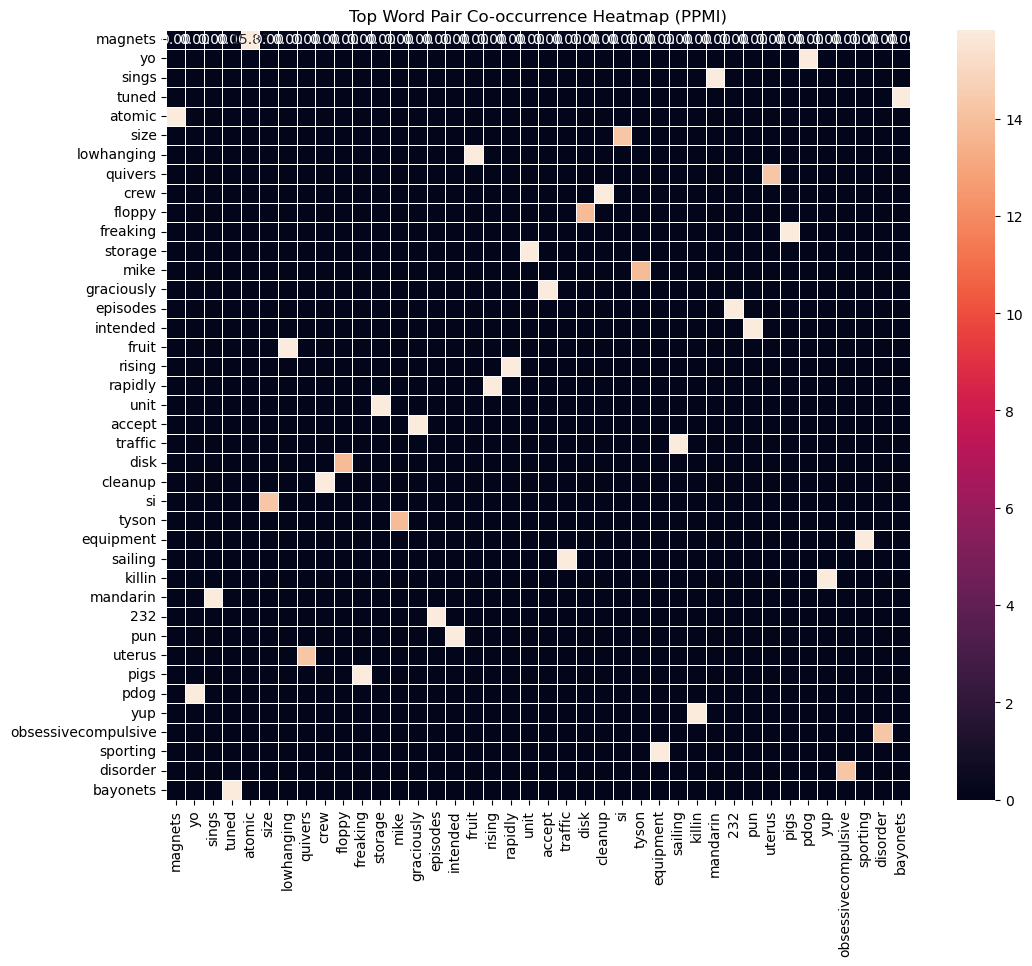

In [163]:
# Plot heatmap based on these pairs
word_pair_heatmap(ppmi_matrix, top_pairs, word_to_id)
